In [72]:
from scipy.io.wavfile import read
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import numpy as np
import cython
import math
from scipy.io.wavfile import write, read
from scipy.fftpack import fft, ifft
from scipy.signal import triang
from scipy.signal import get_window
import copy
import librosa
from scipy.stats import skew
import librosa.display
import pandas as pd

In [124]:
# Libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, find
from itertools import combinations
import copy

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline

import skimage
from skimage import measure
from skimage.measure import block_reduce
import scipy.sparse.linalg as ll
import math
import scipy.io as sio
import scipy

# 1. Feature Extraction function

In [4]:
def extract_features(y,sr,fftl = 2048,hopl =250,winl = 1000,wintype = 'blackmanharris'):
    
    #STFT calculation
    S = np.abs(librosa.stft(y=y,n_fft=fftl, hop_length=hopl, win_length=winl, window=wintype))
    
    # a) Calculating MFCC coeffs
    mfccs = librosa.feature.mfcc(y=y, sr=sr,n_fft=fftl, hop_length=hopl, win_length=winl, window=wintype)
    #collecting mfcc features
    mf_features = mfccs[:5,]

    # mean, variance and skewness of first 5 components
    features = np.concatenate((mf_features.mean(axis=1),mf_features.var(axis=1),skew(mf_features,axis=1)))
    
    
    # b) Centroid features
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr,n_fft=fftl, hop_length=hopl, win_length=winl, window=wintype)
    centroid=np.reshape(centroid, centroid.shape[1])
    # adding centroid mean and centroid variance as features
    features = np.concatenate((features,np.array([centroid.mean(),centroid.var()])))
    
    #c) Spectral rolloff:
    rollof= librosa.feature.spectral_rolloff(y=y, sr=sr,n_fft=fftl, hop_length=hopl, win_length=winl, window=wintype)
    rollof=np.reshape(rollof, rollof.shape[1])
    #mean and variance of rolloff is added
    features = np.concatenate((features,np.array([rollof.mean(),rollof.var()])))
    
    #d) RMS Energy for low energy feature
    energyrms=librosa.feature.rms(y=y, hop_length=hopl)
    energyrms=np.reshape(energyrms, energyrms.shape[1])
    # % of frames that have energy levels lower than the mean energy levels
    low_energy=sum(energyrms<energyrms.mean())/len(energyrms)
    # add low energy features
    features = np.concatenate((features,np.array([low_energy])))
    
    
    #e) Zero crossings
    num_zerocross=sum(librosa.zero_crossings(y))
    features = np.concatenate((features,np.array([num_zerocross])))
    
    #f) CHroma / pitch
    chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
    pitch_class = chroma_cq.mean(axis=1)
    features = np.concatenate((features,pitch_class))
    
    
    #g) Ryhtm feature
    hop_length = hopl
    oenv = librosa.onset.onset_strength(y, sr=sr,hop_length=hop_length )
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                      hop_length=hop_length)
    tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr)
    features_rhythm = np.array([np.mean(tempogram[5:],axis=1).max(),np.mean(tempogram[5:],axis=1).sum(),tempo.item()])
    features = np.concatenate((features,features_rhythm))
    
    return features
    
    
    

In [5]:
# Test feature Extraction function
y, sr = librosa.load("for_experiment.wav")
extract_features(y,sr)

array([-1.69009216e+02,  1.15409645e+02, -1.77943573e+01,  4.01894608e+01,
       -1.03748798e+01,  5.62675928e+03,  5.70477417e+02,  3.78532471e+02,
        2.06879532e+02,  2.43164490e+02, -9.34692174e-02,  1.41157657e-01,
       -1.70934089e-02, -3.53556782e-01, -5.73543191e-01,  1.87862859e+03,
        2.58808924e+05,  3.99860523e+03,  1.39968697e+06,  5.46072508e-01,
        5.98100000e+04,  4.41602618e-01,  4.76759017e-01,  7.08077312e-01,
        3.13685864e-01,  3.74551892e-01,  4.06817645e-01,  4.72964823e-01,
        4.53643918e-01,  4.15040821e-01,  5.06794870e-01,  3.19951683e-01,
        3.45000088e-01,  6.18396037e-01,  6.71335457e+01,  9.57031250e+01])

# 2. Loading the data and creating feature space

In [31]:
#load the blues
feature_blue = np.empty([100, 36])
for i in range(100):
    path = "data/genres.tar/genres/blues/"
    filename = "blues.00000"
    y, sr = librosa.load(path+filename[:-len(str(i))]+str(i)+".wav")
    feature_blue[i]= extract_features(y,sr)
    print("done: ",i)

done:  0
done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14
done:  15
done:  16
done:  17
done:  18
done:  19
done:  20
done:  21
done:  22
done:  23
done:  24
done:  25
done:  26
done:  27
done:  28
done:  29
done:  30
done:  31
done:  32
done:  33
done:  34
done:  35
done:  36
done:  37
done:  38
done:  39
done:  40
done:  41
done:  42
done:  43
done:  44
done:  45
done:  46
done:  47
done:  48
done:  49
done:  50
done:  51
done:  52
done:  53
done:  54
done:  55
done:  56
done:  57
done:  58
done:  59
done:  60
done:  61
done:  62
done:  63
done:  64
done:  65
done:  66
done:  67
done:  68
done:  69
done:  70
done:  71
done:  72
done:  73
done:  74
done:  75
done:  76
done:  77
done:  78
done:  79
done:  80
done:  81
done:  82
done:  83
done:  84
done:  85
done:  86
done:  87
done:  88
done:  89
done:  90
done:  91
done:  92
done:  93
done:  94
done:  95
done:  96
done:  97
done:  98
done:  99


In [33]:
#load the classical
feature_classical = np.empty([100, 36])
for i in range(100):
    path = "data/genres.tar/genres/classical/"
    filename = "classical.00000"
    y, sr = librosa.load(path+filename[:-len(str(i))]+str(i)+".wav")
    feature_classical[i]= extract_features(y,sr)
    print("done: ",i)

done:  0
done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14
done:  15
done:  16
done:  17
done:  18
done:  19
done:  20
done:  21
done:  22
done:  23
done:  24
done:  25
done:  26
done:  27
done:  28
done:  29
done:  30
done:  31
done:  32
done:  33
done:  34
done:  35
done:  36
done:  37
done:  38
done:  39
done:  40
done:  41
done:  42
done:  43
done:  44
done:  45
done:  46
done:  47
done:  48
done:  49
done:  50
done:  51
done:  52
done:  53
done:  54
done:  55
done:  56
done:  57
done:  58
done:  59
done:  60
done:  61
done:  62
done:  63
done:  64
done:  65
done:  66
done:  67
done:  68
done:  69
done:  70
done:  71
done:  72
done:  73
done:  74
done:  75
done:  76
done:  77
done:  78
done:  79
done:  80
done:  81
done:  82
done:  83
done:  84
done:  85
done:  86
done:  87
done:  88
done:  89
done:  90
done:  91
done:  92
done:  93
done:  94
done:  95
done:  96
done:  97
done:  98
done:  99


In [34]:
#load the country
feature_country = np.empty([100, 36])
for i in range(100):
    path = "data/genres.tar/genres/country/"
    filename = "country.00000"
    y, sr = librosa.load(path+filename[:-len(str(i))]+str(i)+".wav")
    feature_country[i]= extract_features(y,sr)
    print("done: ",i)

done:  0
done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14
done:  15
done:  16
done:  17
done:  18
done:  19
done:  20
done:  21
done:  22
done:  23
done:  24
done:  25
done:  26
done:  27
done:  28
done:  29
done:  30
done:  31
done:  32
done:  33
done:  34
done:  35
done:  36
done:  37
done:  38
done:  39
done:  40
done:  41
done:  42
done:  43
done:  44
done:  45
done:  46
done:  47
done:  48
done:  49
done:  50
done:  51
done:  52
done:  53
done:  54
done:  55
done:  56
done:  57
done:  58
done:  59
done:  60
done:  61
done:  62
done:  63
done:  64
done:  65
done:  66
done:  67
done:  68
done:  69
done:  70
done:  71
done:  72
done:  73
done:  74
done:  75
done:  76
done:  77
done:  78
done:  79
done:  80
done:  81
done:  82
done:  83
done:  84
done:  85
done:  86
done:  87
done:  88
done:  89
done:  90
done:  91
done:  92
done:  93
done:  94
done:  95
done:  96
done:  97
done:  98
done:  99


In [37]:
#load the disco
feature_disco = np.empty([100, 36])
for i in range(100):
    path = "data/genres.tar/genres/disco/"
    filename = "disco.00000"
    y, sr = librosa.load(path+filename[:-len(str(i))]+str(i)+".wav")
    feature_disco[i]= extract_features(y,sr)
    print("done: ",i)

done:  0
done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14
done:  15
done:  16
done:  17
done:  18
done:  19
done:  20
done:  21
done:  22
done:  23
done:  24
done:  25
done:  26
done:  27
done:  28
done:  29
done:  30
done:  31
done:  32
done:  33
done:  34
done:  35
done:  36
done:  37
done:  38
done:  39
done:  40
done:  41
done:  42
done:  43
done:  44
done:  45
done:  46
done:  47
done:  48
done:  49
done:  50
done:  51
done:  52
done:  53
done:  54
done:  55
done:  56
done:  57
done:  58
done:  59
done:  60
done:  61
done:  62
done:  63
done:  64
done:  65
done:  66
done:  67
done:  68
done:  69
done:  70
done:  71
done:  72
done:  73
done:  74
done:  75
done:  76
done:  77
done:  78
done:  79
done:  80
done:  81
done:  82
done:  83
done:  84
done:  85
done:  86
done:  87
done:  88
done:  89
done:  90
done:  91
done:  92
done:  93
done:  94
done:  95
done:  96
done:  97
done:  98
done:  99


In [38]:
#load the hiphop
feature_hiphop = np.empty([100, 36])
for i in range(100):
    path = "data/genres.tar/genres/hiphop/"
    filename = "hiphop.00000"
    y, sr = librosa.load(path+filename[:-len(str(i))]+str(i)+".wav")
    feature_hiphop[i]= extract_features(y,sr)
    print("done: ",i)

done:  0
done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14
done:  15
done:  16
done:  17
done:  18
done:  19
done:  20
done:  21
done:  22
done:  23
done:  24
done:  25
done:  26
done:  27
done:  28
done:  29
done:  30
done:  31
done:  32
done:  33
done:  34
done:  35
done:  36
done:  37
done:  38
done:  39
done:  40
done:  41
done:  42
done:  43
done:  44
done:  45
done:  46
done:  47
done:  48
done:  49
done:  50
done:  51
done:  52
done:  53
done:  54
done:  55
done:  56
done:  57
done:  58
done:  59
done:  60
done:  61
done:  62
done:  63
done:  64
done:  65
done:  66
done:  67
done:  68
done:  69
done:  70
done:  71
done:  72
done:  73
done:  74
done:  75
done:  76
done:  77
done:  78
done:  79
done:  80
done:  81
done:  82
done:  83
done:  84
done:  85
done:  86
done:  87
done:  88
done:  89
done:  90
done:  91
done:  92
done:  93
done:  94
done:  95
done:  96
done:  97
done:  98
done:  99


In [39]:
#load the jazz
feature_jazz = np.empty([100, 36])
for i in range(100):
    path = "data/genres.tar/genres/jazz/"
    filename = "jazz.00000"
    y, sr = librosa.load(path+filename[:-len(str(i))]+str(i)+".wav")
    feature_jazz[i]= extract_features(y,sr)
    print("done: ",i)

done:  0
done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14
done:  15
done:  16
done:  17
done:  18
done:  19
done:  20
done:  21
done:  22
done:  23
done:  24
done:  25
done:  26
done:  27
done:  28
done:  29
done:  30
done:  31
done:  32
done:  33
done:  34
done:  35
done:  36
done:  37
done:  38
done:  39
done:  40
done:  41
done:  42
done:  43
done:  44
done:  45
done:  46
done:  47
done:  48
done:  49
done:  50
done:  51
done:  52
done:  53
done:  54
done:  55
done:  56
done:  57
done:  58
done:  59
done:  60
done:  61
done:  62
done:  63
done:  64
done:  65
done:  66
done:  67
done:  68
done:  69
done:  70
done:  71
done:  72
done:  73
done:  74
done:  75
done:  76
done:  77
done:  78
done:  79
done:  80
done:  81
done:  82
done:  83
done:  84
done:  85
done:  86
done:  87
done:  88
done:  89
done:  90
done:  91
done:  92
done:  93
done:  94
done:  95
done:  96
done:  97
done:  98
done:  99


In [40]:
#load the metal
feature_metal = np.empty([100, 36])
for i in range(100):
    path = "data/genres.tar/genres/metal/"
    filename = "metal.00000"
    y, sr = librosa.load(path+filename[:-len(str(i))]+str(i)+".wav")
    feature_metal[i]= extract_features(y,sr)
    print("done: ",i)

done:  0
done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14
done:  15
done:  16
done:  17
done:  18
done:  19
done:  20
done:  21
done:  22
done:  23
done:  24
done:  25
done:  26
done:  27
done:  28
done:  29
done:  30
done:  31
done:  32
done:  33
done:  34
done:  35
done:  36
done:  37
done:  38
done:  39
done:  40
done:  41
done:  42
done:  43
done:  44
done:  45
done:  46
done:  47
done:  48
done:  49
done:  50
done:  51
done:  52
done:  53
done:  54
done:  55
done:  56
done:  57
done:  58
done:  59
done:  60
done:  61
done:  62
done:  63
done:  64
done:  65
done:  66
done:  67
done:  68
done:  69
done:  70
done:  71
done:  72
done:  73
done:  74
done:  75
done:  76
done:  77
done:  78
done:  79
done:  80
done:  81
done:  82
done:  83
done:  84
done:  85
done:  86
done:  87
done:  88
done:  89
done:  90
done:  91
done:  92
done:  93
done:  94
done:  95
done:  96
done:  97
done:  98
done:  99


In [41]:
#load the pop
feature_pop = np.empty([100, 36])
for i in range(100):
    path = "data/genres.tar/genres/pop/"
    filename = "pop.00000"
    y, sr = librosa.load(path+filename[:-len(str(i))]+str(i)+".wav")
    feature_pop[i]= extract_features(y,sr)
    print("done: ",i)

done:  0
done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14
done:  15
done:  16
done:  17
done:  18
done:  19
done:  20
done:  21
done:  22
done:  23
done:  24
done:  25
done:  26
done:  27
done:  28
done:  29
done:  30
done:  31
done:  32
done:  33
done:  34
done:  35
done:  36
done:  37
done:  38
done:  39
done:  40
done:  41
done:  42
done:  43
done:  44
done:  45
done:  46
done:  47
done:  48
done:  49
done:  50
done:  51
done:  52
done:  53
done:  54
done:  55
done:  56
done:  57
done:  58
done:  59
done:  60
done:  61
done:  62
done:  63
done:  64
done:  65
done:  66
done:  67
done:  68
done:  69
done:  70
done:  71
done:  72
done:  73
done:  74
done:  75
done:  76
done:  77
done:  78
done:  79
done:  80
done:  81
done:  82
done:  83
done:  84
done:  85
done:  86
done:  87
done:  88
done:  89
done:  90
done:  91
done:  92
done:  93
done:  94
done:  95
done:  96
done:  97
done:  98
done:  99


In [42]:
#load the reggae
feature_reggae = np.empty([100, 36])
for i in range(100):
    path = "data/genres.tar/genres/reggae/"
    filename = "reggae.00000"
    y, sr = librosa.load(path+filename[:-len(str(i))]+str(i)+".wav")
    feature_reggae[i]= extract_features(y,sr)
    print("done: ",i)

done:  0
done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14
done:  15
done:  16
done:  17
done:  18
done:  19
done:  20
done:  21
done:  22
done:  23
done:  24
done:  25
done:  26
done:  27
done:  28
done:  29
done:  30
done:  31
done:  32
done:  33
done:  34
done:  35
done:  36
done:  37
done:  38
done:  39
done:  40
done:  41
done:  42
done:  43
done:  44
done:  45
done:  46
done:  47
done:  48
done:  49
done:  50
done:  51
done:  52
done:  53
done:  54
done:  55
done:  56
done:  57
done:  58
done:  59
done:  60
done:  61
done:  62
done:  63
done:  64
done:  65
done:  66
done:  67
done:  68
done:  69
done:  70
done:  71
done:  72
done:  73
done:  74
done:  75
done:  76
done:  77
done:  78
done:  79
done:  80
done:  81
done:  82
done:  83
done:  84
done:  85
done:  86
done:  87
done:  88
done:  89
done:  90
done:  91
done:  92
done:  93
done:  94
done:  95
done:  96
done:  97
done:  98
done:  99


In [43]:
#load the rock
feature_rock = np.empty([100, 36])
for i in range(100):
    path = "data/genres.tar/genres/rock/"
    filename = "rock.00000"
    y, sr = librosa.load(path+filename[:-len(str(i))]+str(i)+".wav")
    feature_rock[i]= extract_features(y,sr)
    print("done: ",i)

done:  0
done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14
done:  15
done:  16
done:  17
done:  18
done:  19
done:  20
done:  21
done:  22
done:  23
done:  24
done:  25
done:  26
done:  27
done:  28
done:  29
done:  30
done:  31
done:  32
done:  33
done:  34
done:  35
done:  36
done:  37
done:  38
done:  39
done:  40
done:  41
done:  42
done:  43
done:  44
done:  45
done:  46
done:  47
done:  48
done:  49
done:  50
done:  51
done:  52
done:  53
done:  54
done:  55
done:  56
done:  57
done:  58
done:  59
done:  60
done:  61
done:  62
done:  63
done:  64
done:  65
done:  66
done:  67
done:  68
done:  69
done:  70
done:  71
done:  72
done:  73
done:  74
done:  75
done:  76
done:  77
done:  78
done:  79
done:  80
done:  81
done:  82
done:  83
done:  84
done:  85
done:  86
done:  87
done:  88
done:  89
done:  90
done:  91
done:  92
done:  93
done:  94
done:  95
done:  96
done:  97
done:  98
done:  99


In [25]:
b = np.array([1,2])
c= np.array([3,4])

In [28]:
a = np.concatenate((a,b),axis=0)
a = np.concatenate((a,c),axis=0)
a

array([0, 0, 1, 2, 3, 4])

In [29]:
feature_blue = np.empty([100, 36])


array([[ 1.22645785e-311,  1.22645822e-311, -1.79060326e+001, ...,
         7.08657214e-001,  5.84507852e+001,  9.22851562e+001],
       [-2.66074249e+002,  1.30199295e+002,  1.09601879e+001, ...,
         5.06237632e-001,  4.49695118e+001,  9.22851562e+001],
       [-1.51234406e+002,  1.46775543e+002, -2.70382843e+001, ...,
         6.91721894e-001,  5.16631238e+001,  7.83025568e+001],
       ...,
       [-2.08017578e+002,  1.54026642e+002, -4.63205957e+000, ...,
         6.46104554e-001,  6.14781313e+001,  1.17453835e+002],
       [-1.50656937e+002,  1.02374290e+002, -2.20165920e+001, ...,
         6.71178717e-001,  5.48226739e+001,  1.23046875e+002],
       [-2.93053860e+011,  1.99381071e-305,  1.22645755e-311, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])

array([-2.66074249e+02,  1.30199295e+02,  1.09601879e+01,  3.57731438e+01,
        2.39217663e+00,  8.14784570e+03,  6.91215820e+02,  6.52516724e+02,
        3.04883362e+02,  3.28076324e+02, -4.65953171e-01, -8.72240588e-02,
       -9.97917533e-01, -1.84121981e-01, -1.47098809e-01,  1.41820813e+03,
        3.69354470e+05,  3.16986559e+03,  2.92170713e+06,  5.22658610e-01,
        3.71400000e+04,  4.98805553e-01,  3.62076372e-01,  4.02565598e-01,
        3.01093042e-01,  3.90189230e-01,  4.80788797e-01,  5.14642596e-01,
        8.40023339e-01,  5.58993280e-01,  5.00855803e-01,  4.78440434e-01,
        3.92507881e-01,  5.06237632e-01,  4.49695118e+01,  9.22851562e+01])

In [32]:
feature_blue

array([[-172.45413208,  125.54541016,  -17.90603256, ...,    0.70865721,
          58.45078524,   92.28515625],
       [-266.07424927,  130.19929504,   10.96018791, ...,    0.50623763,
          44.96951184,   92.28515625],
       [-151.23440552,  146.77554321,  -27.0382843 , ...,    0.69172189,
          51.66312376,   78.30255682],
       ...,
       [-208.01757812,  154.02664185,   -4.63205957, ...,    0.64610455,
          61.47813126,  117.45383523],
       [-150.65693665,  102.37429047,  -22.01659203, ...,    0.67117872,
          54.82267385,  123.046875  ],
       [-234.11135864,  140.90632629,  -24.01859474, ...,    0.56234876,
          60.34756347,  129.19921875]])

In [35]:
feature_classical

array([[-316.32598877,  145.64111328,  -33.97508621, ...,    0.81256081,
          85.73307456,   95.703125  ],
       [-365.24707031,  148.96347046,  -24.94811249, ...,    0.80685722,
          96.845117  ,  123.046875  ],
       [-285.63397217,  149.82296753,  -33.80052567, ...,    0.86017807,
          84.04302079,   99.38401442],
       ...,
       [-329.01165771,  133.82476807,  -14.52235794, ...,    0.88062011,
          88.04280861,  103.359375  ],
       [-336.21304321,  113.63406372,  -34.79666901, ...,    0.68434319,
          60.14950724,   92.28515625],
       [-423.46185303,  138.11827087,  -17.64659882, ...,    0.73914575,
          90.20016674,  123.046875  ]])

In [36]:
feature_country

array([[ -74.13852692,   80.16915131,    7.94057608, ...,    0.746273  ,
          84.76891867,  123.046875  ],
       [ -61.32304001,   68.78235626,    1.71847069, ...,    0.85233778,
          89.17501694,  129.19921875],
       [-175.07299805,   86.95069122,   10.33956242, ...,    0.66832525,
          64.20955738,   80.74951172],
       ...,
       [-197.02207947,  138.75331116,  -14.61587143, ...,    0.59200684,
          58.1521634 ,  151.99908088],
       [-183.97216797,  144.34846497,  -17.05203819, ...,    0.69768412,
          61.44142799,  117.45383523],
       [ -98.01940155,  112.89295197,  -21.30906105, ...,    0.75030346,
          59.12938017,  143.5546875 ]])

In [44]:
feature_jazz

array([[-3.07404877e+02,  1.43344345e+02, -9.00627995e+00, ...,
         6.41667322e-01,  6.21356758e+01,  1.17453835e+02],
       [-3.99690704e+02,  1.53210495e+02,  3.81110162e-02, ...,
         5.99163145e-01,  6.85079894e+01,  1.12347147e+02],
       [-2.96172028e+02,  1.92055801e+02, -4.38586655e+01, ...,
         5.35334015e-01,  6.39746364e+01,  1.43554688e+02],
       ...,
       [-4.62500793e+02,  1.32706818e+02,  3.57038803e+01, ...,
         5.27419366e-01,  6.36816846e+01,  1.07666016e+02],
       [-2.75576996e+02,  1.12096596e+02,  2.27605724e+00, ...,
         5.51107197e-01,  5.73673204e+01,  1.12347147e+02],
       [-3.67062531e+02,  1.23362511e+02,  1.20934258e+01, ...,
         6.18191230e-01,  5.67252535e+01,  1.03359375e+02]])

In [45]:
feature_metal

array([[-110.61303711,   54.93733597,  -10.93297863, ...,    0.86209907,
          93.93965004,   95.703125  ],
       [-138.80418396,   66.72567749,  -13.7405262 , ...,    0.83987237,
          88.61489775,  143.5546875 ],
       [-120.23459625,  117.46932983,  -39.76177597, ...,    0.77324395,
          85.01298974,  112.34714674],
       ...,
       [-140.2406311 ,  101.44123077,  -14.3669157 , ...,    0.66739777,
          67.33894043,  151.99908088],
       [-155.44073486,   94.95748901,  -24.2706604 , ...,    0.56790182,
          37.15353654,   75.99954044],
       [-127.3033905 ,   91.76383209,  -24.14433289, ...,    0.57299321,
          53.71408265,  143.5546875 ]])

In [46]:
feature_pop

array([[-151.49719238,   62.89647293,   31.11685371, ...,    0.75328987,
          57.57139335,  129.19921875],
       [-125.12271118,   48.05154419,   39.05594635, ...,    0.74437656,
          59.9861712 ,  103.359375  ],
       [-120.51600647,   68.46385956,   33.83255005, ...,    0.78210125,
          48.8892836 ,  123.046875  ],
       ...,
       [-191.5213623 ,   57.16416168,   41.7758255 , ...,    0.67485804,
          38.53749358,   95.703125  ],
       [ -90.52997589,   51.22943497,   11.49744034, ...,    0.70908322,
          44.82015806,  112.34714674],
       [-177.15647888,   94.78440857,   38.29088211, ...,    0.54699361,
          41.4892343 ,   78.30255682]])

In [47]:
feature_reggae

array([[-218.53717041,  111.90331268,   -8.65708542, ...,    0.75214798,
          53.2686581 ,   95.703125  ],
       [-248.06669617,  134.28018188,    0.58098388, ...,    0.7539795 ,
          42.8782344 ,   75.99954044],
       [-259.93682861,  116.32089996,    9.71983528, ...,    0.80001795,
          42.63596785,   99.38401442],
       ...,
       [-196.9012146 ,  111.19606781,  -11.04845428, ...,    0.70060929,
          77.78270518,  129.19921875],
       [-198.91981506,   99.89809418,   12.49727917, ...,    0.69395733,
          42.77909032,  117.45383523],
       [-126.11236572,   92.65310669,  -40.60429001, ...,    0.68669132,
          58.14676053,  117.45383523]])

In [48]:
feature_rock

array([[-169.00921631,  115.40964508,  -17.7943573 , ...,    0.61839604,
          67.13354573,   95.703125  ],
       [-164.3097229 ,  141.19064331,  -20.69379234, ...,    0.64181133,
          65.29940637,  143.5546875 ],
       [-180.13890076,  121.88686371,  -21.70390701, ...,    0.61047594,
          24.84613853,  103.359375  ],
       ...,
       [-178.91630554,  119.69779968,  -44.54217148, ...,    0.82007667,
          81.72998573,  123.046875  ],
       [-277.9604187 ,  130.64227295,   -4.52885151, ...,    0.69111976,
          71.44200238,  107.66601562],
       [-281.45028687,  135.85290527,  -17.35821342, ...,    0.70117158,
          74.74845465,  123.046875  ]])

In [70]:
feature_space = np.concatenate((feature_blue,feature_classical,feature_country,feature_disco,feature_hiphop,feature_jazz, feature_metal,feature_pop,feature_reggae,feature_rock),axis = 0)
feature_space.shape

(1000, 36)

In [75]:
# convert array into dataframe
DF = pd.DataFrame(feature_space,columns = ["mfcc_mean1","mfcc_mean2","mfcc_mean3","mfcc_mean4","mfcc_mean5","mfcc_var1","mfcc_var2","mfcc_var3","mfcc_var4","mfcc_var5","mfcc_skew1","mfcc_skew2","mfcc_skew3","mfcc_skew4","mfcc_skew5","centroid_mean","centroid_var","rolloff_mean","rolloff_var","low_energy","zero_cross","pitch1","pitch2","pitch3","pitch4","pitch5","pitch6","pitch7","pitch8","pitch9","pitch10","pitch11","pitch12","tempo_max","tempo_sum","tempo_beat"])
  
# save the dataframe as a csv file
DF.to_csv("feature_data.csv")

In [79]:
y= np.array([1]*100+[2]*100+[3]*100+[4]*100+[5]*100+[6]*100+[7]*100+[8]*100+[9]*100+[10]*100)
y=y.reshape((-1,1))
feature_space1 = np.concatenate((feature_space,y),axis = 1)


(1000, 36)

In [80]:
feature_space1.shape

(1000, 37)

In [81]:
# convert array into dataframe
DF = pd.DataFrame(feature_space1,columns = ["mfcc_mean1","mfcc_mean2","mfcc_mean3","mfcc_mean4","mfcc_mean5","mfcc_var1","mfcc_var2","mfcc_var3","mfcc_var4","mfcc_var5","mfcc_skew1","mfcc_skew2","mfcc_skew3","mfcc_skew4","mfcc_skew5","centroid_mean","centroid_var","rolloff_mean","rolloff_var","low_energy","zero_cross","pitch1","pitch2","pitch3","pitch4","pitch5","pitch6","pitch7","pitch8","pitch9","pitch10","pitch11","pitch12","tempo_max","tempo_sum","tempo_beat","label"])
  
# save the dataframe as a csv file
DF.to_csv("full_data.csv")

# 3. Feature Correlation

In [82]:
DF.head()

,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_var1,mfcc_var2,mfcc_var3,mfcc_var4,mfcc_var5,...,pitch7,pitch8,pitch9,pitch10,pitch11,pitch12,tempo_max,tempo_sum,tempo_beat,label
0,-172.454132,125.545410,-17.906033,42.438969,-6.789933,2769.290039,368.034363,275.400452,183.746689,202.428406,...,0.629727,0.691256,0.497805,0.517267,0.546683,0.561303,0.708657,58.450785,92.285156,1.0
1,-266.074249,130.199295,10.960188,35.773144,2.392177,8147.845703,691.215820,652.516724,304.883362,328.076324,...,0.514643,0.840023,0.558993,0.500856,0.478440,0.392508,0.506238,44.969512,92.285156,1.0
2,-151.234406,146.775543,-27.038284,31.192139,-14.001049,3883.053711,637.288025,505.552124,192.588303,203.338745,...,0.425309,0.444536,0.362131,0.476622,0.384076,0.657711,0.691722,51.663124,78.302557,1.0
3,-256.472382,158.852554,9.814706,29.920855,3.362334,5730.113770,550.050293,303.199341,201.771622,317.954315,...,0.213386,0.197043,0.210052,0.226063,0.268214,0.477259,0.510860,43.476813,89.102909,1.0
4,-221.848846,133.984055,-30.359127,19.948652,-32.481678,5491.850586,1004.528320,383.256439,243.707947,372.264313,...,0.336665,0.405459,0.421962,0.656349,0.655042,0.338964,0.610888,50.692646,103.359375,1.0


In [179]:
X = DF.loc[:,["mfcc_mean1","mfcc_mean2","mfcc_mean3","mfcc_mean4","mfcc_mean5","mfcc_var1","mfcc_var2","mfcc_var3","mfcc_var4","mfcc_var5","mfcc_skew1","mfcc_skew2","mfcc_skew3","mfcc_skew4","mfcc_skew5","centroid_mean","centroid_var","rolloff_mean","rolloff_var","low_energy","zero_cross","pitch1","pitch2","pitch3","pitch4","pitch5","pitch6","pitch7","pitch8","pitch9","pitch10","pitch11","pitch12","tempo_max","tempo_sum","tempo_beat"]]
y = DF["label"]

In [180]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [95]:
import seaborn as sns
#ax = sns.heatmap(np.corrcoef(X), annot=True)

In [ ]:
a=5

In [100]:
corr_mat=np.corrcoef(X.T)

<AxesSubplot:>

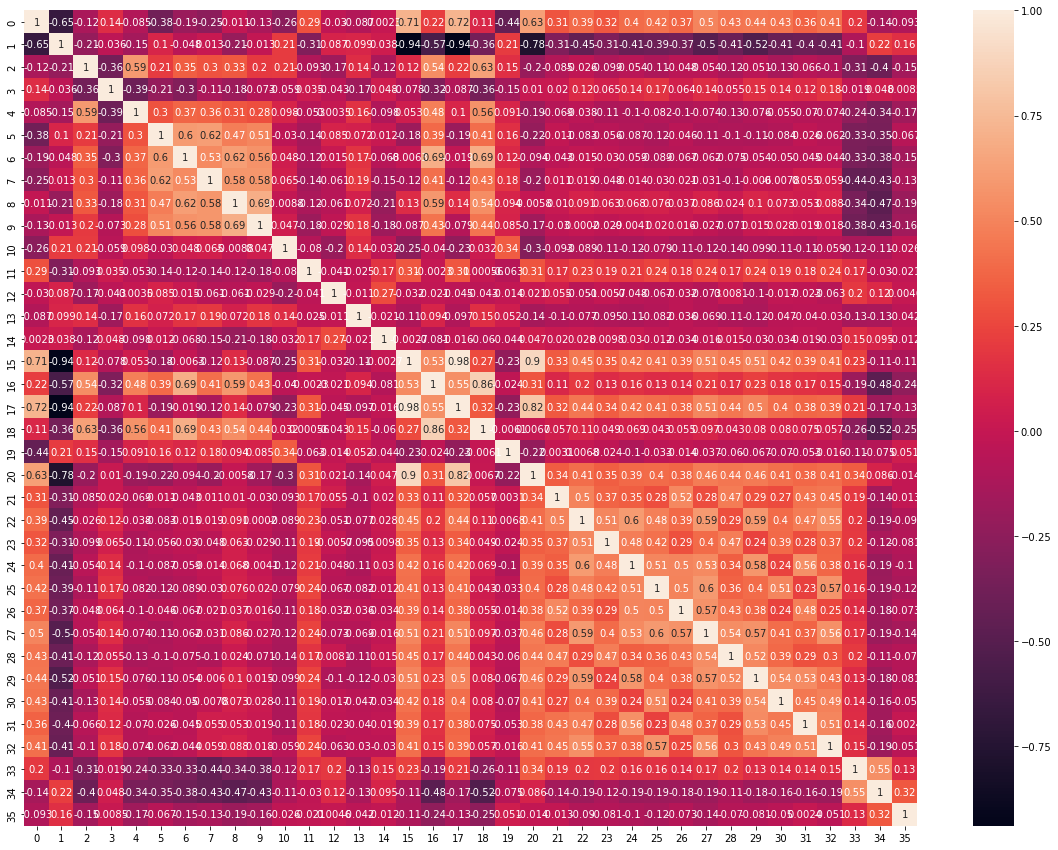

In [107]:
fig, ax = plt.subplots(figsize=(20,15))  
sns.heatmap(corr_mat,annot=True,ax=ax)

# 4. PCA Visualization of data

In [110]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_new=pca.fit_transform(X)

In [112]:
X_new.shape

(1000, 2)

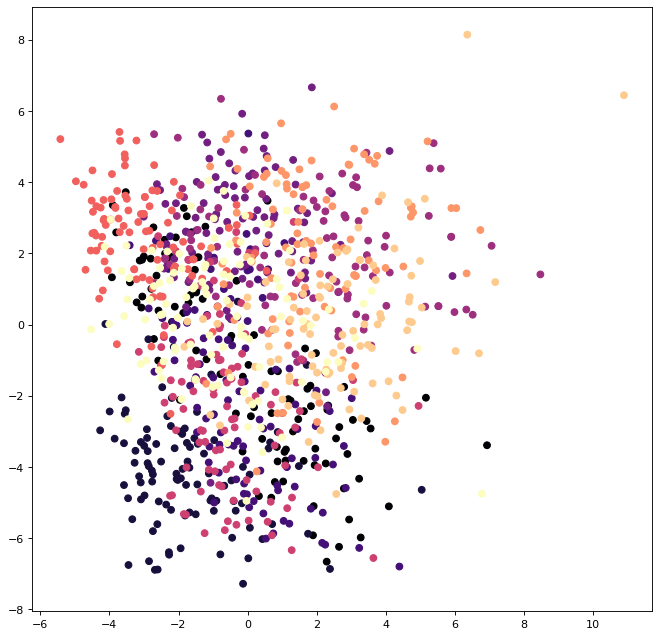

In [121]:
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(X_new[:,1],X_new[:,0], c = y , cmap = "magma")

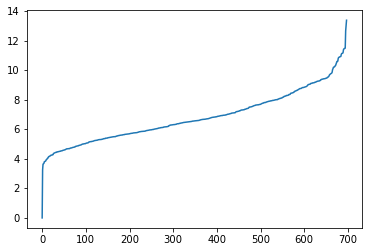

In [131]:
data = X.T  # dimension X samples
# How to select epsilon
a = np.zeros(698) # store distance
pt =0
for i in range(697):
    a[i]=np.linalg.norm(data[:,pt]-data[:,i+1]) # calculate distance between point pt and all other data points

idx=np.argsort(a) #sort distances
plt.plot(a[idx]) # observe how distance changes 

In [132]:
#STEP1: creating an Adjacency matrix
A =  np.zeros((698,698)) 
epsilon = 15
A = scipy.spatial.distance.cdist(data.T , data.T)
A[A>epsilon]=0

In [133]:
#adjacency plot
import pandas as pd
import networkx as nx
df= pd.DataFrame(A)
G = nx.Graph(df.values)

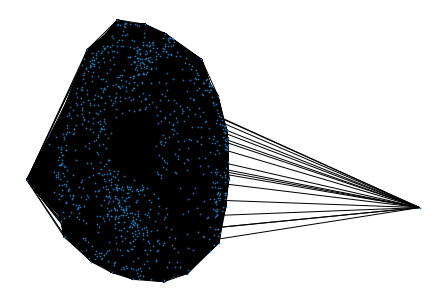

In [134]:
nx.draw(G,node_size=0.5)

# Outlier Detection - Visualizing globally (KDE)

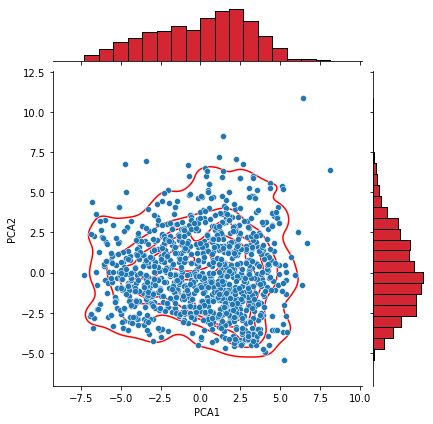

In [139]:
#2D kde plot
pca_df = pd.DataFrame(X_new,columns = ["PCA1","PCA2"])

g= sns.jointplot(data=pca_df,x='PCA1',y="PCA2")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6, bw_adjust=0.7)
g.plot_marginals(sns.histplot, color="r")

# Outlier Detection - Visualizing Locally (LOF)

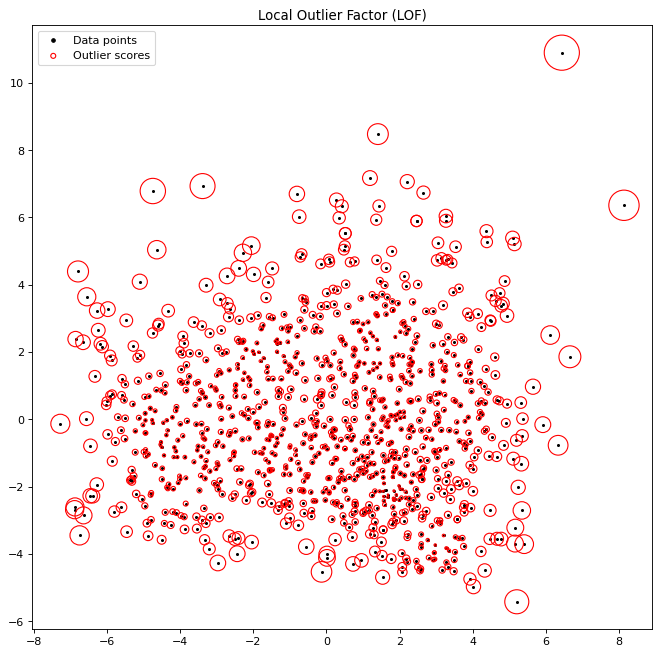

In [145]:
#Local outlier factor 

from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=30, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X_new)
#n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_


plt.figure(figsize=(10, 10), dpi=80)
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_new[:, 0], X_new[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X_new[:, 0],
    X_new[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
#plt.axis("tight")
#plt.xlim((-5, 5))
#plt.ylim((-5, 5))
#plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [149]:
X_scores.max()-X_scores.min()

2.1783543410252433

In [160]:
(X_scores.max() - (1))/2.17

-0.902473010656718

In [153]:
X_scores.min()

-3.1367207741503216

In [157]:
X_scores[X_scores<-1.5]

array([-1.50528654, -2.06156328, -1.54298193, -1.6127823 , -1.55673414,
       -1.59692009, -1.53697292, -1.7373027 , -1.80503514, -1.64521632,
       -1.72235757, -1.53856228, -1.97666057, -1.57930054, -1.56646644,
       -2.5799392 , -3.13672077, -1.70457531, -2.09193854])

In [162]:
X_scores.min()

-3.1367207741503216

### Visualizing after removing the outliers

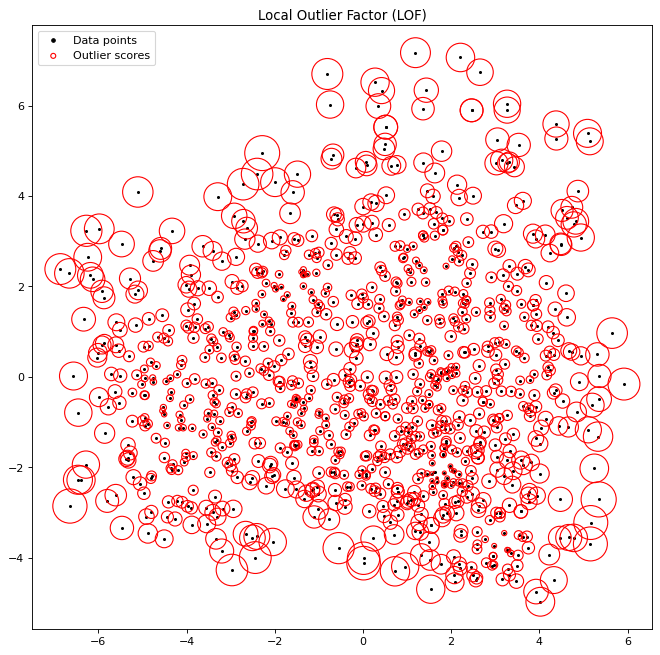

In [165]:
plt.figure(figsize=(10, 10), dpi=80)
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_new[X_scores>-1.5, 0], X_new[X_scores>-1.5, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores[X_scores>-1.5].max() - X_scores[X_scores>-1.5]) / (X_scores[X_scores>-1.5].max() - X_scores[X_scores>-1.5].min())
plt.scatter(
    X_new[X_scores>-1.5, 0],
    X_new[X_scores>-1.5, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
#plt.axis("tight")
#plt.xlim((-5, 5))
#plt.ylim((-5, 5))
#plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

#plt.scatter(X_new[X_scores>-1.5,0],X_new[X_scores>-1.5,1])

### Removing LOF based outliers from the main data

In [167]:
#Removing Outliers; Appling LOF on entire dataset
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=30, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
#n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

(1000, 2)

In [176]:
X.shape

(1000, 36)

In [184]:
X_PO= X[X_scores>-1.4]
y_PO= y[X_scores>-1.4]

In [185]:
X_PO.shape

(985, 36)

# Splitting Training and Test data

In [186]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_PO, y_PO, test_size=0.25, random_state=42)

In [187]:
X_train.shape

(738, 36)

In [188]:
X_test.shape

(247, 36)

In [189]:
y_train.shape

(738,)

In [190]:
y_test.shape

(247,)

# ISOMAP visuals

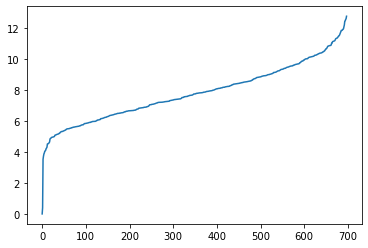

In [198]:
data = X_train.T  # dimension X samples

# How to select epsilon
a = np.zeros(698) # store distance
pt =0
for i in range(697):
    a[i]=np.linalg.norm(data[:,pt]-data[:,i+1]) # calculate distance between point pt and all other data points

idx=np.argsort(a) #sort distances
plt.plot(a[idx]) # observe how distance changes 

#STEP1: creating an Adjacency matrix
A =  np.zeros((698,698)) 
epsilon = 8
A = scipy.spatial.distance.cdist(data.T , data.T)
A[A>epsilon]=0

In [199]:
#adjacency plot
import pandas as pd
import networkx as nx
df= pd.DataFrame(A)
G = nx.Graph(df.values)

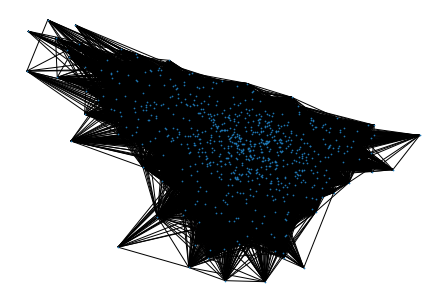

In [202]:
nx.draw(G,node_size=0.5)

In [203]:
# convert array into dataframe
DF1 = pd.DataFrame(X_train,columns = ["mfcc_mean1","mfcc_mean2","mfcc_mean3","mfcc_mean4","mfcc_mean5","mfcc_var1","mfcc_var2","mfcc_var3","mfcc_var4","mfcc_var5","mfcc_skew1","mfcc_skew2","mfcc_skew3","mfcc_skew4","mfcc_skew5","centroid_mean","centroid_var","rolloff_mean","rolloff_var","low_energy","zero_cross","pitch1","pitch2","pitch3","pitch4","pitch5","pitch6","pitch7","pitch8","pitch9","pitch10","pitch11","pitch12","tempo_max","tempo_sum","tempo_beat"])
  
# save the dataframe as a csv file
DF1.to_csv("X_train.csv")

In [204]:
# convert array into dataframe
DF1 = pd.DataFrame(X_test,columns = ["mfcc_mean1","mfcc_mean2","mfcc_mean3","mfcc_mean4","mfcc_mean5","mfcc_var1","mfcc_var2","mfcc_var3","mfcc_var4","mfcc_var5","mfcc_skew1","mfcc_skew2","mfcc_skew3","mfcc_skew4","mfcc_skew5","centroid_mean","centroid_var","rolloff_mean","rolloff_var","low_energy","zero_cross","pitch1","pitch2","pitch3","pitch4","pitch5","pitch6","pitch7","pitch8","pitch9","pitch10","pitch11","pitch12","tempo_max","tempo_sum","tempo_beat"])
  
# save the dataframe as a csv file
DF1.to_csv("X_test.csv")

In [205]:
# convert array into dataframe
DF1 = pd.DataFrame(y_test,columns = ["label"])
  
# save the dataframe as a csv file
DF1.to_csv("y_test.csv")

In [206]:
# convert array into dataframe
DF1 = pd.DataFrame(y_train,columns = ["label"])
  
# save the dataframe as a csv file
DF1.to_csv("y_train.csv")